xarray.Dataset {
dimensions:
	lat = 96 ;
	lon = 144 ;
	age = 120 ;

variables:
	float32 lat(lat) ;
		lat:FillValue = 9.969209968386869e+36 ;
		lat:long_name = vector latitudes ;
		lat:units = degrees_north ;
	float32 lon(lon) ;
		lon:FillValue = 9.969209968386869e+36 ;
		lon:long_name = vector of longitudes ;
		lon:units = degrees_east ;
	float32 age(age) ;
		age:long_name = reconstruction bin mid-point (years BP) ;
	float32 sat(age, lat, lon) ;
		sat:FillValue = 9.969209968386869e+36 ;
		sat:long_name = ENSEMBLE MEAN (n = 500) mean annual temperature at reference height ;
		sat:units = degrees Celsius ;
	float32 sat_std(age, lat, lon) ;
		sat_std:FillValue = 9.969209968386869e+36 ;
		sat_std:long_name = ENSEMBLE STANDARD DEVIATION (n = 500) mean annual temperature at reference height ;
		sat_std:units = degrees Celsius ;

// global attributes:
}

d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


   LibSize       X:Y       Y:X
0     10.0  0.554443  0.665578
1     20.0  0.687649  0.781093
2     30.0  0.761912  0.847047
3     40.0  0.877775  0.855767
4     50.0  0.913843  0.868268
5     60.0  0.956827  0.891788
6     70.0  0.978497  0.890925
Columns: Index(['LibSize', 'X:Y', 'Y:X'], dtype='object')


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


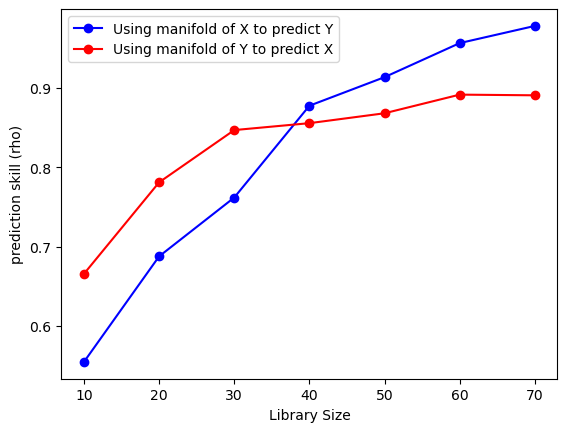

In [2]:
# read the LGMR_SAT_climo.nc under LGMR_data

import xarray as xr
import pandas as pd


ds_sat = xr.open_dataset('LGMR_data/LGMR_SAT_climo.nc')
ds_sat.info()

df_pre = pd.read_csv(r"D:\VScode\Inso_LGMR\inso_data\pre.csv")


# Prepare DataFrame
df = pd.DataFrame({
    'Time': ds_sat['age'].values,
    'X': df_pre['pre'].values,
    'Y': ds_sat['sat'].isel(lat=80).isel(lon=0).values
})

import pandas as pd
import numpy as np
from pyEDM import CCM
import matplotlib.pyplot as plt


# Prepare DataFrame
df = pd.DataFrame({
    'Time': ds_sat['age'].values,
    'X': df_pre['pre'].values,
    'Y': ds_sat['sat'].isel(lat=80).isel(lon=0).values
})

# # plot df
# plt.plot(df['Time'], df['X'], 'b-')
# plt.plot(df['Time'], df['Y'], 'r-')



# CCM call
ccm_out = CCM(
    dataFrame   = df,
    E           = 3,
    tau         = 2,
    columns     = "X",   # predictor
    target      = "Y",   # target
    libSizes    = "10 20 30 40 50 60 70",
    sample      = 10,
    random      = True,
    replacement = False,
    Tp          = -7
)

print(ccm_out)
print("Columns:", ccm_out.columns)

# plot the results
plt.plot(ccm_out['LibSize'], ccm_out['X:Y'], 'bo-', label='Using manifold of X to predict Y')
plt.plot(ccm_out['LibSize'], ccm_out['Y:X'], 'ro-', label='Using manifold of Y to predict X')
plt.xlabel("Library Size")
plt.ylabel('prediction skill (rho)')
plt.legend()
plt.show()

d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
d:\Users\User\an

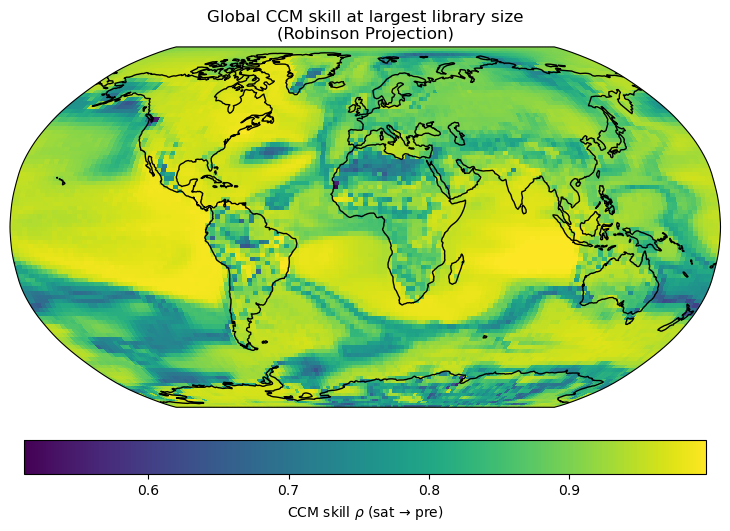

In [8]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyEDM import CCM

# Cartopy imports
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# # ------------------------------------------------
# # 1. Load data & fix FillValue
# # ------------------------------------------------
# ds_sat = xr.open_dataset("LGMR_data/LGMR_SAT_climo.nc")
# fillval = ds_sat["sat"]._FillValue
# ds_sat["sat"] = ds_sat["sat"].where(ds_sat["sat"] != fillval)

# df_pre = pd.read_csv("inso_data/pre.csv")  # your precession data

# Make sure these match in length
assert len(df_pre) == ds_sat.sizes["age"], "Timeseries length mismatch"

# ------------------------------------------------
# 2. Prepare for loop
# ------------------------------------------------
nlat = ds_sat.sizes["lat"]
nlon = ds_sat.sizes["lon"]
ages = ds_sat["age"].values

rho_map = np.full((nlat, nlon), np.nan)

# CCM parameters
E = 3
tau = 2
libSizes = "10 20 30 40 50 60 70"
Tp = 7  # or -7 if you want to match your original code

# ------------------------------------------------
# 3. Main loop over lat/lon
# ------------------------------------------------
for iLat in range(nlat):
    for iLon in range(nlon):
        # Extract the local "sat" time series
        sat_ts = ds_sat["sat"].isel(lat=iLat, lon=iLon).values

        # Build temp DataFrame for pyEDM
        # We want "Y->X", i.e. sat->pre:
        # columns="Y", target="X"
        temp_df = pd.DataFrame({
            "Time": ages,
            "X": df_pre["pre"],  # we want to predict X
            "Y": sat_ts,         # from Y
        })

        # Run CCM
        ccm_out = CCM(
            dataFrame   = temp_df,
            E           = E,
            tau         = tau,
            columns     = "Y",
            target      = "X",
            libSizes    = libSizes,
            sample      = 10,
            random      = True,
            replacement = False,
            Tp          = Tp
        )

        # Extract the mean rho at the largest library size
        largest_L = ccm_out["LibSize"].max()
        mask_last = ccm_out["LibSize"] == largest_L
        rho_at_largest = ccm_out.loc[mask_last, "Y:X"].mean()

        rho_map[iLat, iLon] = rho_at_largest

# ------------------------------------------------
# 4. Plot the global map with Robinson projection
# ------------------------------------------------
lats = ds_sat["lat"].values
lons = ds_sat["lon"].values

fig = plt.figure(figsize=(11, 6))
# Create a cartopy GeoAxes in Robinson projection
ax = plt.axes(projection=ccrs.Robinson())

# If your data is in lat, lon => ( -90..+90 , -180..+180 ), you can directly plot
# Set transform=ccrs.PlateCarree() to tell cartopy how the data is geographically referenced
pcm = ax.pcolormesh(
    lons, lats, rho_map,
    transform=ccrs.PlateCarree(),  # data is lat/lon
    shading="auto"
)

# Add coastlines
ax.coastlines()
# Optionally add other features:
# ax.add_feature(cfeature.BORDERS, linewidth=0.5)
# ax.add_feature(cfeature.LAND, facecolor='lightgray')  # if desired

# Add a colorbar
cb = plt.colorbar(pcm, orientation="horizontal", pad=0.07, shrink=0.8)
cb.set_label(r"CCM skill $\rho$ (sat $\to$ pre)")

plt.title("Global CCM skill at largest library size\n(Robinson Projection)")
plt.show()


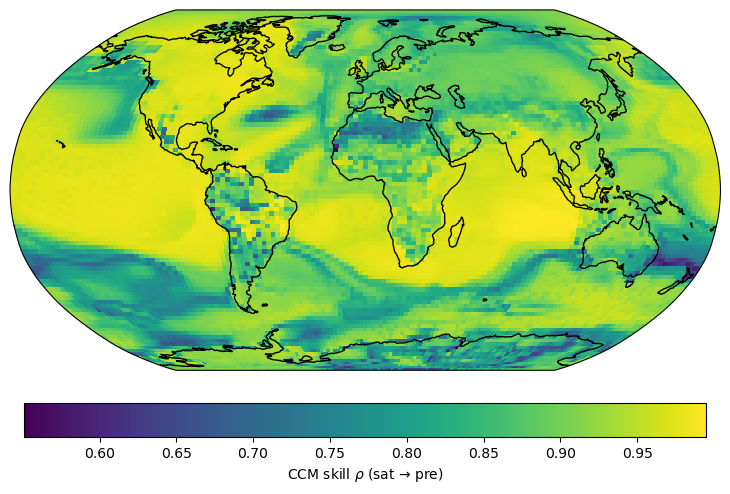

In [6]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

lats = ds_sat["lat"].values
lons = ds_sat["lon"].values

fig = plt.figure(figsize=(11, 6))
# Create a cartopy GeoAxes in Robinson projection
ax = plt.axes(projection=ccrs.Robinson())

# If your data is in lat, lon => ( -90..+90 , -180..+180 ), you can directly plot
# Set transform=ccrs.PlateCarree() to tell cartopy how the data is geographically referenced
pcm = ax.pcolormesh(
    lons, lats, rho_map,
    transform=ccrs.PlateCarree(),  # data is lat/lon
    shading="auto"
)

# Add coastlines
ax.coastlines()
# Optionally add other features:
# ax.add_feature(cfeature.BORDERS, linewidth=0.5)
# ax.add_feature(cfeature.LAND, facecolor='lightgray')  # if desired

# Add a colorbar
cb = plt.colorbar(pcm, orientation="horizontal", pad=0.07, shrink=0.8)
cb.set_label(r"CCM skill $\rho$ (sat $\to$ pre)")

# plt.title("Global CCM skill at largest library size\n(Robinson Projection)")
plt.show()

In [7]:
# save the rhomap to /output/
np.save("output/rho_map.npy", rho_map)

In [ ]:
# 

d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
d:\Users\User\an

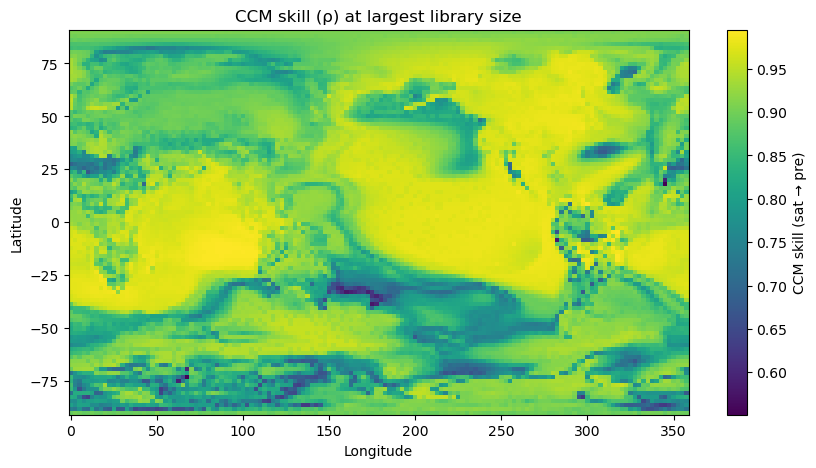

In [ ]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyEDM import CCM



# Confirm that 'pre' aligns with ds_sat['age'] in length:
# e.g. ds_sat.sizes['age'] = 120, so df_pre.shape[0] should be 120
assert len(df_pre) == ds_sat.sizes["age"], "precession timeseries must match ds_sat age dimension"

# ------------------------------------------------
# 2. Prepare for loop
# ------------------------------------------------
nlat = ds_sat.sizes["lat"]
nlon = ds_sat.sizes["lon"]
ages = ds_sat["age"].values

# We'll store the CCM skill (rho) in a 2D array
rho_map = np.full((nlat, nlon), np.nan)

# We will use these fixed CCM parameters for all grid points
E = 3
tau = 2
# We'll test library sizes from 10 to 70, stepping by 10
libSizes = "10 20 30 40 50 60 70"

# ------------------------------------------------
# 3. Main loop over lat/lon
# ------------------------------------------------
for iLat in range(nlat):
    for iLon in range(nlon):
        # Extract the local "sat" time series
        sat_ts = ds_sat["sat"].isel(lat=iLat, lon=iLon).values

        # Build a temporary DataFrame for pyEDM
        # We want to test: "Y:X" (meaning does Y->X?), so
        #   columns="Y", target="X"
        #   Y = sat_ts, X = pre
        temp_df = pd.DataFrame({
            "Time": ages,
            "X": df_pre["pre"],   # target
            "Y": sat_ts          # predictor
        })

        # Run CCM: from sat_ts to pre
        ccm_out = CCM(
            dataFrame   = temp_df,
            E           = E,
            tau         = tau,
            columns     = "Y",    # manifold from 'Y'
            target      = "X",    # trying to predict 'X'
            libSizes    = libSizes,
            sample      = 10,
            random      = True,
            replacement = False,
            Tp          = 0  # or whatever prediction horizon you want; your example used -7
        )

        # ccm_out has multiple rows (one for each library size * each sample)
        # We'll keep the mean rho at the largest library size
        largest_L = ccm_out["LibSize"].max()
        mask_last = ccm_out["LibSize"] == largest_L

        # The column name for skill of Y->X is "Y:X"
        # Take the average of these final replicates
        rho_at_largest = ccm_out.loc[mask_last, "Y:X"].mean()

        # Store in our map
        rho_map[iLat, iLon] = rho_at_largest

# ------------------------------------------------
# 4. Plot the global map
# ------------------------------------------------
# Make sure we have lat, lon in increasing order if needed
lats = ds_sat["lat"].values
lons = ds_sat["lon"].values

# Simple plot using pcolormesh
plt.figure(figsize=(10, 5))
# If your lat is from -90..90 and lon from 0..360 or -180..180, adapt accordingly
# shading='auto' ensures no dimension mismatch messages
plt.pcolormesh(lons, lats, rho_map, shading='auto')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
cb = plt.colorbar()
cb.set_label("CCM skill (sat → pre)")
plt.title("CCM skill (\u03C1) at largest library size")
plt.show()
